# Parte I: predicción de precios de alojamientos con MLP

Statistical Learning II

*Rodrigo Chang*

*Carné: 19000625*

En esta parte se implmementa un modelo de redes neuronales para la predicción del precio de alojamientos con un conjunto de datos de Airbnb. Se plantea como hipótesis que este modelo puede predecir mejor el precio que un modelo de regresión lineal multivariado.

**Nota: este cuaderno posee algunas visualizaciones interactivas, que Github no permite cargar en su sitio. Para visualizar de mejor forma este cuaderno, diríjase al sitio: https://nbviewer.jupyter.org y copie la URL de este cuaderno**

***
<a id="acerca-airbnb"></a>
# Acerca de Airbnb

<!--![airbnb_logo_detail.jpg](attachment:airbnb_logo_detail.jpg)-->

A‌i‌r‌b‌n‌b‌, ‌ ‌I‌n‌c‌.‌ es un mercado en línea para organizar u ofrecer alojamiento, principalmente casas de familia o experiencias de turismo. La compañía no posee ninguno de los listados de bienes raíces, ni organiza eventos; actúa como un corredor, recibiendo comisiones de cada reserva. La compañía tiene su sede en San Francisco, California, Estados Unidos.

La compañía fue concebida después de que sus fundadores pusieron un colchón de aire en su sala de estar, convirtiendo efectivamente su apartamento en una cama y desayuno, para compensar el alto costo del alquiler en San Francisco; Airbnb es una versión abreviada de su nombre original, AirBedandBreakfast.com.

En lugar de copiar sitios de viajes como Expedia y Travelocity, Airbnb adopta un enfoque único hacia el alojamiento. Parte de la "economía compartida", Airbnb le ofrece el hogar de alguien como un lugar para quedarse en lugar de un hotel. En Airbnb, puede encontrar lugares para quedarse en su viaje de mochilero por Europa, o puede encontrar un lugar para quedarse durante un mes durante su pasantía en Los Ángeles. Además, si desea alquilar espacio adicional en su propia casa, puede alojar a través de Airbnb y ganar dinero por permitir que un huésped pase la noche.

***
<a id="carga-librerias"></a>
## Carga de librerías

In [4]:
import numpy as np
import pandas as pd

In [85]:
# Gráficas y mapas
import matplotlib.pyplot as plt
import plotly as plotly
import seaborn as sns
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster
from folium import plugins

# Modelo de regresión lineal
from sklearn.linear_model import LinearRegression
# Preprocesamiento
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
# Métricas de evaluación
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [83]:
# Gráficas de plotly
import plotly.offline as py 
import plotly.graph_objs as go
import plotly.express as px
from plotly.offline import init_notebook_mode, plot
from plotly import tools
init_notebook_mode(connected=True)

***
## Carga de datos del archivo CSV

In [8]:
# Carga de datos
df = pd.read_csv('AB_NYC_2019.csv')
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [9]:
# Información del dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
id                                48895 non-null int64
name                              48879 non-null object
host_id                           48895 non-null int64
host_name                         48874 non-null object
neighbourhood_group               48895 non-null object
neighbourhood                     48895 non-null object
latitude                          48895 non-null float64
longitude                         48895 non-null float64
room_type                         48895 non-null object
price                             48895 non-null int64
minimum_nights                    48895 non-null int64
number_of_reviews                 48895 non-null int64
last_review                       38843 non-null object
reviews_per_month                 38843 non-null float64
calculated_host_listings_count    48895 non-null int64
availability_365                  48895 non-null int64

***
## Análisis exploratorio 

### Visualizaciones con *folium*
Obtendremos unas visualizaciones dinámicas de mapa para mostrar el número de *reviews* y el precio de los diferentes alojamientos en el conjunto de datos.

In [12]:
print('Alojamientos con mayor número de reviews')

# Obtenemos dataframe ordenado con primeros 1000 registros con más reviews
df1 = df.sort_values(by=['number_of_reviews'], ascending=False).head(1000)

# Mapa de folium
mapdf1 = folium.Map([40.8, -73.8],
    zoom_start=11,
    tiles='Stamen Terrain')

# Agregamos clusters
mapdf1_rooms_map = plugins.MarkerCluster().add_to(mapdf1)
# Se marcan las posiciones con el nombre de los alojamientos 
for lat, lon, label in zip(df1.latitude, df1.longitude, df1.name):
    folium.Marker(location=[lat,lon],
                  icon=folium.Icon(icon='home'),
                  popup=label).add_to(mapdf1_rooms_map)
mapdf1.add_child(mapdf1_rooms_map)
mapdf1

Alojamientos con mayor número de reviews


<img src="folium-1.png" alt="Mapa de Folium">

In [13]:
print('Alojamientos más caros')

# Obtenemos dataframe ordenado con primeros 1000 registros con más reviews
df2=df.sort_values(by=['price'],ascending=False).head(1000)
# Mapa de folium
mapdf1=folium.Map(location=[40.80,-73.80],
                  zoom_start=10, 
                  tiles='Stamen Terrain')

# Se marcan las posiciones con el nombre de los alojamientos 
mapdf1_rooms_map=plugins.MarkerCluster().add_to(mapdf1)
for lat,lon,label in zip(df2.latitude, df2.longitude, df2.name):
    folium.Marker(location=[lat, lon],
                  icon=folium.Icon(icon='home'),
                  popup=label).add_to(mapdf1_rooms_map)
mapdf1.add_child(mapdf1_rooms_map)

mapdf1

Alojamientos más caros


<img src="folium-2.png" alt="Mapa de Folium">

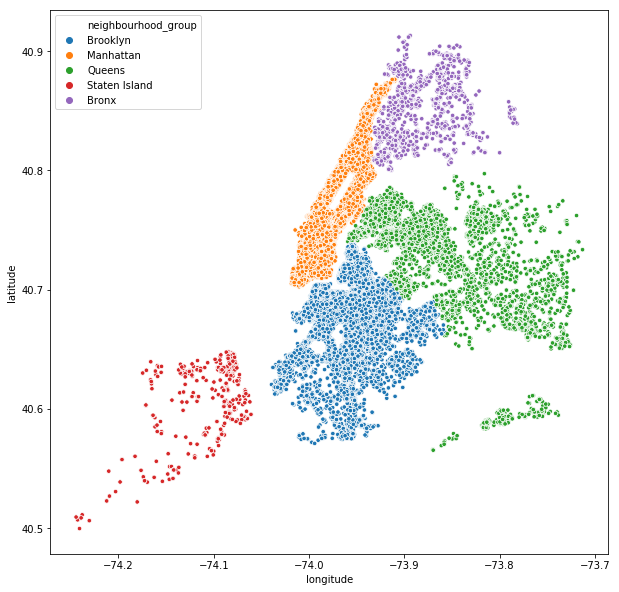

In [17]:
# Gráfica del grupo o vecindario de los alojamientos
plt.figure(figsize=(10,10))
sns.scatterplot(x='longitude', y='latitude', hue='neighbourhood_group',s=20, data=df)
plt.show()

In [20]:
# Estadísticas por vecindario
df3 = df.groupby(['neighbourhood_group']).mean()
df3.drop(['latitude', 'longitude','host_id','id'], axis=1)

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
neighbourhood_group,,,,,,
Bronx,87.496792,4.560953,26.004583,1.837831,2.233731,165.758937
Brooklyn,124.383207,6.056556,24.202845,1.283212,2.284371,100.232292
Manhattan,196.875814,8.579151,20.985596,1.272131,12.791330,111.979410
Queens,99.517649,5.181433,27.700318,1.941200,4.060184,144.451818
Staten Island,114.812332,4.831099,30.941019,1.872580,2.319035,199.678284


### Gráfica de barras por vecindario

In [28]:
df4 = df.groupby(['neighbourhood_group','neighbourhood']).mean()

r1=df4.loc['Bronx'].number_of_reviews.sum().round()
r2=df4.loc['Brooklyn'].number_of_reviews.sum().round()
r3=df4.loc['Manhattan'].number_of_reviews.sum().round()
r4=df4.loc['Queens'].number_of_reviews.sum().round()
r5=df4.loc['Staten Island'].number_of_reviews.sum().round()

In [29]:
neigh_group = df['neighbourhood_group'].value_counts()
neigh_group_df = pd.DataFrame(neigh_group)
neigh_group_df.reset_index(inplace=True)


In [30]:
reviews = [r1,r2,r3,r4,r5]
review = pd.DataFrame(data=reviews, index=neigh_group_df['index'], columns=['values'],)
review.reset_index(inplace=True)

trace10 = go.Bar(x=review['index'],
                 y=review['values'],
                 marker=dict(color=['Blue','Red','Green','Black','Purple']),
                 width=0.4)
layout = go.Layout(title='Número de reviews por vecindario',
                   height=400,
                   width=800)
fig = go.Figure(data=[trace10],layout=layout)
py.iplot(fig)

In [33]:
# Estadísticas por grupo de vecindario y tipo de habitaciones
df5 = df.groupby(['neighbourhood_group','room_type']).mean()
room_types_neighbourhoods = df5.drop(['id', 'host_id', 'latitude', 'longitude',
                                      'number_of_reviews','reviews_per_month'], axis=1)
# Mostrar el dataframe
room_types_neighbourhoods

price  minimum_nights  \
neighbourhood_group room_type                                     
Bronx               Entire home/apt  127.506596        5.957784   
                    Private room      66.788344        3.858896   
                    Shared room       59.800000        3.366667   
Brooklyn            Entire home/apt  178.327545        6.531332   
                    Private room      76.500099        5.539479   
                    Shared room       50.527845        7.753027   
Manhattan           Entire home/apt  249.239109       10.539283   
                    Private room     116.776622        5.446880   
                    Shared room       88.977083        6.766667   
Queens              Entire home/apt  147.050573        5.369752   
                    Private room      71.762456        5.120107   
                    Shared room       69.020202        4.232323   
Staten Island       Entire home/apt  173.846591        6.238636   
                    Private room      62.292553        3.632979   
                    Shared room       57.444444        2.333333   

                                     calculated_host_listings_count  \
neighbourhood_group room_type                                         
Bronx               Entire home/apt                        1.865435   
                    Private room                           2.338957   
                    Shared room                            3.416667   
Brooklyn            Entire home/apt                        1.837849   
                    Private room                           2.547177   
                    Shared room                            6.171913   
Manhattan           Entire home/apt                       18.922721   
                    Private room                           3.188048   
                    Shared room                            3.885417   
Queens              Entire home/apt                        1.677958   
                    Private room                           5.559905   
                    Shared room                            3.737374   
Staten Island       Entire home/apt                        1.596591   
                    Private room                           2.840426   
                    Shared room                            5.555556   

                                     availability_365  
neighbourhood_group room_type                          
Bronx               Entire home/apt        158.000000  
                    Private room           171.331288  
                    Shared room            154.216667  
Brooklyn            Entire home/apt         97.205147  
                    Private room            99.917983  
                    Shared room            178.007264  
Manhattan           Entire home/apt        117.140996  
                    Private room           101.845026  
                    Shared room            138.572917  
Queens              Entire home/apt        132.267176  
                    Private room           149.222716  
                    Shared room            192.186869  
Staten Island       Entire home/apt        178.073864  
                    Private room           226.361702  
                    Shared room             64.777778

In [34]:
# Correlaciones por grupos
fig = px.scatter_matrix(room_types_neighbourhoods,
                        height=1000,
                        width=900,
                        color="minimum_nights")
fig.update_traces(diagonal_visible=False)
fig.show()

In [35]:
# Estadísticas por tipo de habitaciones
df6 = df.groupby(['room_type']).mean()
room_types = df6.drop(['id', 'host_id', 'latitude', 'longitude',
                       'number_of_reviews','reviews_per_month'], axis=1)
room_types

,price,minimum_nights,calculated_host_listings_count,availability_365
room_type,,,,
Entire home/apt,211.794246,8.506907,10.698335,111.920304
Private room,89.780973,5.377900,3.227717,111.203933
Shared room,70.127586,6.475000,4.662931,162.000862


<a id="procesamiento-prediccion"></a>
## Procesamiento y preparación de datos para predicción

In [206]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [208]:
# Creamos una copia del dataframe para manipularlo
#df1 = df.copy()
df1 = df[df["price"] <= 1000].copy()

# Quitamos columnas no numéricas y columnas con valores NaN
df1.drop(['name', 'id', 'host_name', 'host_id', 'last_review'], axis=1, inplace=True)
df1['reviews_per_month'] = df1['reviews_per_month'].replace(np.nan, 0)

# Codificamos los tipos de vecindario
le = preprocessing.LabelEncoder()
le.fit(df1['neighbourhood_group'])    
df1['neighbourhood_group']=le.transform(df1['neighbourhood_group'])

# Codificamos el vecindario ?
le = preprocessing.LabelEncoder()
le.fit(df1['neighbourhood'])
df1['neighbourhood'] = le.transform(df1['neighbourhood'])

# Codificación del tipo de habitación
le = preprocessing.LabelEncoder()
le.fit(df1['room_type'])
df1['room_type']=le.transform(df1['room_type'])

# Ordenar las observaciones por precio
df1.sort_values(by='price', ascending=True, inplace=True)

# Visualizar el dataframe
print("Número de observaciones: ", len(df1))
df1.head()

Número de observaciones:  48656


,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
25778,1,214,40.70838,-73.94645,0,0,5,3,0.15,1,73
26841,1,28,40.69211,-73.90670,2,0,30,2,0.11,6,333
25433,0,62,40.83296,-73.88668,1,0,2,55,2.56,4,127
23161,1,13,40.69023,-73.95428,1,0,4,1,0.05,4,28
25753,1,91,40.72462,-73.94072,1,0,2,12,0.53,2,0


In [209]:
regressors = ['neighbourhood_group', 'latitude','longitude','room_type',
              'minimum_nights','number_of_reviews','reviews_per_month',
              'calculated_host_listings_count','availability_365']
X = df1[regressors]
y = df1['price']

In [210]:
# Transformación de y
print("Máximo valor de precio: ", y.max())
y = y / 1000
print("Máximo valor reescalado: ", y.max())

Máximo valor de precio:  1000
Máximo valor reescalado:  1.0


In [211]:
# Transformación de media y desviación estándar
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)
print(X.shape)

(48656, 9)


## Conjunto de entrenamiento y pruebas

In [212]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [213]:
X_train.shape, X_test.shape

((38924, 9), (9732, 9))

## Modelo de regresión lineal
A continuación, se entrenará un modelo de regresión lineal como punto de comparación para el modelo de perceptrones multicapa. Para esto, se comparará el RMSE sobre el conjunto de pruebas y el $R^2$ del modelo.

In [214]:
# Ajustar un modelo de regresión lineal 
lm = LinearRegression()
lm.fit(X_train, y_train)

# Obtener las predicciones
predicts = lm.predict(X_test)

In [215]:
print("RMSE= %0.4f, R^2 = %0.2f" % (np.sqrt(metrics.mean_squared_error(y_test, predicts)), 
                                   r2_score(y_test, predicts)))

RMSE= 0.0923, R^2 = 0.30


In [216]:
# Algunos errores 
error_diff = pd.DataFrame({'Actual Values': np.array(y_test).flatten(), 'Predicted Values': predicts.flatten()})
1000*error_diff.head(5)

,Actual Values,Predicted Values
0,100.0,165.805909
1,70.0,178.067292
2,72.0,70.655379
3,140.0,130.661799
4,120.0,166.547324


### Gráficas de valores observados y ajustados por el modelo lineal

In [217]:
# Mostrar algunos valores ajustados y observados
fig = go.Figure(data = [
    go.Bar(name='Pronosticado', x=error_diff.head(20).index, y=error_diff['Predicted Values'].head(20)),
    go.Bar(name='Actual', x=error_diff.head(20).index, y=error_diff['Actual Values'].head(20))
])

fig.update_layout(barmode='group')
fig.show()

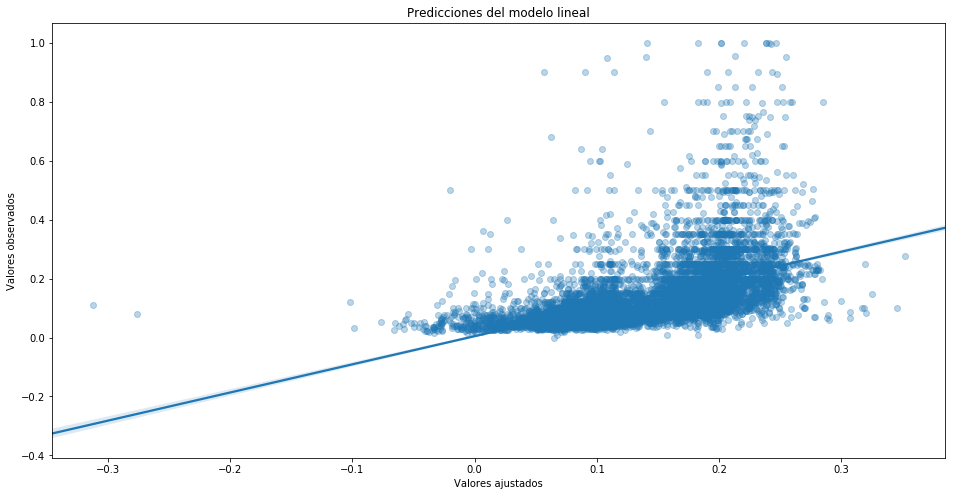

In [219]:
# Gráfica de comparación observados vs ajustados
plt.figure(figsize=(16, 8))
sns.regplot(predicts, y_test, scatter_kws={'alpha':0.3})
plt.xlabel('Valores ajustados')
plt.ylabel('Valores observados')
plt.title("Predicciones del modelo lineal")
plt.show()

***
## Modelo de perceptrones multicapa (MLP)
Ahora se entrenará una red neuronal artificial utilizando capas densas, para ver si el desempeño del modelo es mejor que el del modelo lineal entrenado anteriormente.

In [220]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [221]:
X_train.shape

(38924, 9)

In [222]:
# Definición del modelo
model = Sequential()
model.add(Dense(8, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compilar el modelo 
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 8)                 80        
_________________________________________________________________
dense_36 (Dense)             (None, 5)                 45        
_________________________________________________________________
dense_37 (Dense)             (None, 3)                 18        
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 4         
Total params: 147
Trainable params: 147
Non-trainable params: 0
_________________________________________________________________


In [223]:
# Entrenar el modelo con early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
history = model.fit(X_train, y_train, 
                    epochs=100, validation_split=0.2, 
                    batch_size=1024, verbose=1,
                    callbacks=[es])

Train on 31139 samples, validate on 7785 samples
Epoch 1/100
31139/31139 [==============================] - 1s 26us/step - loss: 0.2266 - val_loss: 0.1372
Epoch 2/100
31139/31139 [==============================] - 0s 4us/step - loss: 0.1224 - val_loss: 0.0827
Epoch 3/100
31139/31139 [==============================] - 0s 3us/step - loss: 0.0799 - val_loss: 0.0565
Epoch 4/100
31139/31139 [==============================] - 0s 4us/step - loss: 0.0557 - val_loss: 0.0395
Epoch 5/100
31139/31139 [==============================] - 0s 4us/step - loss: 0.0406 - val_loss: 0.0294
Epoch 6/100
31139/31139 [==============================] - 0s 4us/step - loss: 0.0313 - val_loss: 0.0234
Epoch 7/100
31139/31139 [==============================] - 0s 3us/step - loss: 0.0253 - val_loss: 0.0192
Epoch 8/100
31139/31139 [==============================] - 0s 4us/step - loss: 0.0210 - val_loss: 0.0166
Epoch 9/100
31139/31139 [==============================] - 0s 4us/step - loss: 0.0180 - val_loss: 0.0148
Epoch

Epoch 78/100
31139/31139 [==============================] - 0s 3us/step - loss: 0.0092 - val_loss: 0.0094
Epoch 79/100
31139/31139 [==============================] - 0s 3us/step - loss: 0.0092 - val_loss: 0.0094
Epoch 80/100
31139/31139 [==============================] - 0s 3us/step - loss: 0.0092 - val_loss: 0.0094
Epoch 81/100
31139/31139 [==============================] - 0s 3us/step - loss: 0.0092 - val_loss: 0.0094
Epoch 82/100
31139/31139 [==============================] - 0s 4us/step - loss: 0.0092 - val_loss: 0.0094
Epoch 83/100
31139/31139 [==============================] - 0s 3us/step - loss: 0.0092 - val_loss: 0.0094
Epoch 84/100
31139/31139 [==============================] - 0s 4us/step - loss: 0.0091 - val_loss: 0.0094
Epoch 85/100
31139/31139 [==============================] - 0s 3us/step - loss: 0.0091 - val_loss: 0.0094
Epoch 86/100
31139/31139 [==============================] - 0s 3us/step - loss: 0.0091 - val_loss: 0.0094
Epoch 87/100
31139/31139 [====================

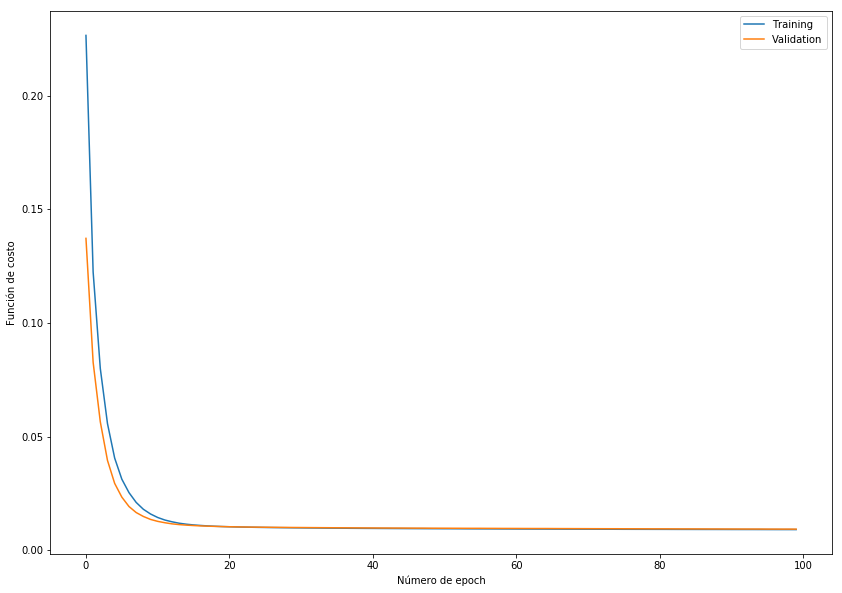

In [224]:
# Graficar la función de costo
plt.figure(figsize=(14,10))
plt.plot(history.history['loss'], label="Training")
plt.plot(history.history['val_loss'], label="Validation")
plt.xlabel("Número de epoch")
plt.ylabel("Función de costo")
plt.legend();

In [225]:
predicts = model.predict(X_test)

In [226]:
print("RMSE= %0.4f, R^2 = %0.2f" % (np.sqrt(metrics.mean_squared_error(y_test, predicts)), 
                                   r2_score(y_test, predicts)))

RMSE= 0.0878, R^2 = 0.37


In [227]:
# Algunos errores 
error_diff = pd.DataFrame({'Actual Values': np.array(y_test).flatten(), 'Predicted Values': predicts.flatten()})
1000*error_diff.sample(10)

,Actual Values,Predicted Values
9055,250.0,116.789536
6025,60.0,71.653755
549,150.0,147.702194
5760,79.0,80.670563
751,80.0,88.096207
5751,160.0,197.627701
2869,219.0,253.197495
4456,155.0,241.595352
3867,128.0,185.156616
2175,45.0,92.994064


### Gráficas de valores observados y ajustados por el modelo lineal

In [228]:
# Mostrar algunos valores ajustados y observados
fig = go.Figure(data = [
    go.Bar(name='Pronosticado', x=error_diff.head(20).index, y=error_diff['Predicted Values'].head(20)),
    go.Bar(name='Actual', x=error_diff.head(20).index, y=error_diff['Actual Values'].head(20))
])

fig.update_layout(barmode='group')
fig.show()

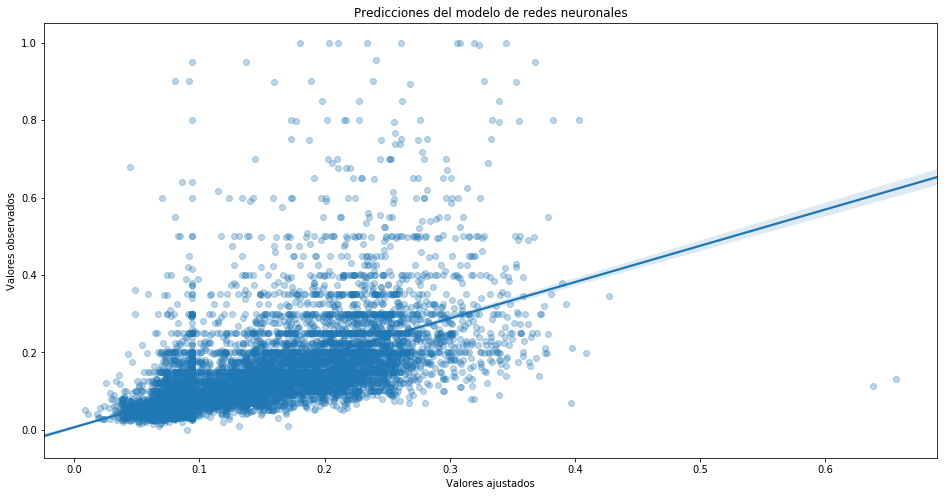

In [233]:
# Gráfica de comparación observados vs ajustados
plt.figure(figsize=(16, 8))
sns.regplot(predicts, y_test, scatter_kws={'alpha':0.3})
plt.xlabel('Valores ajustados')
plt.ylabel('Valores observados')
plt.title("Predicciones del modelo de redes neuronales")
plt.show()

# Conclusiones

Derivado del entrenamiento de un modelo lineal y un modelo de perceptrones multicapa se comparó el desempeño de ambos modelos, utilizando como medida de comparación el RMSE sobre el conjunto de prueba (jamás visto por ninguno de los modelos durante su entrenamiento). 

Se determinó que el modelo de redes neuronales se desempeña mejor que el modelo lineal, obteniendo también un valor de $R^2$ mayor. Esto se debe a que la arquitectura del modelo permite capturar mejor las no linealidades presentes en los datos.

Cabe resaltar el hecho de que, quizás es posible obtener mejores resultados en ambos modelos, pero claramente, sería necesario un mayor esfuerzo en la aplicación de *feature engineering* para los datos de entrada a los modelos.